<a href="https://colab.research.google.com/github/cksdnr1/PyTorchPJ/blob/main/5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}') 

In [6]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

## 3.3 RNN Model Design (Time series)

### 실습 3-1 : Stock prediction


#### **Import Module**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
#from pytorch_lightning.core.lightning import LightningModule
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

torch.__version__, pl.__version__

('1.13.1+cu116', '2.0.0')

#### **DataSet**

##### Load

In [8]:
%%capture
# https://github.com/FinanceData/FinanceDataReader
!pip install finance-datareader    

In [9]:
import FinanceDataReader as fdr

# KOSPI
#pd_data = fdr.DataReader('KS11', '2000-01-01') 

# Samsung(005930), 1992-01-01 ~ 2018-10-31
pd_data = fdr.DataReader('005930', '2000-01-01')

pd_data.head(),pd_data.tail()

(            Open  High   Low  Close   Volume    Change
 Date                                                  
 2000-01-04  6000  6110  5660   6110  1483967  0.148496
 2000-01-05  5800  6060  5520   5580  1493604 -0.086743
 2000-01-06  5750  5780  5580   5620  1087810  0.007168
 2000-01-07  5560  5670  5360   5540   806195 -0.014235
 2000-01-10  5600  5770  5580   5770   937615  0.041516,
              Open   High    Low  Close    Volume    Change
 Date                                                      
 2023-03-17  60800  61300  60600  61300  14090110  0.023372
 2023-03-20  61100  61200  60200  60200   9618009 -0.017945
 2023-03-21  60500  60700  60100  60300   8318514  0.001661
 2023-03-22  61000  61200  60500  61100   8978591  0.013267
 2023-03-23  60600  61800  60600  61800  10470126  0.011457)

#### Preprocessing

In [10]:
# 최대,최소값으로 정규화 하기
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = (np.max(data, 0) - np.min(data, 0)) + 1e-7
    return numerator/denominator  

In [11]:
xy = np.array(pd_data) #np <- pandas data format 

## 필요시 reordering 
#xy = xy[::-1]           # 과거부터로 정렬 (chronically ordered)
xy = MinMaxScaler(xy)   # minmax 정규화
x = xy                  # input data(Open,High,Low,Close,Volume,change)
y = xy[:, [3]]         # 종가만 slicing -> target data

# data type 확인
print ("SHAPE OF X IS %s" % (x.shape,))
print ("SHAPE OF Y IS %s" % (y.shape,))  

SHAPE OF X IS (5734, 6)
SHAPE OF Y IS (5734, 1)


In [12]:
# sequence generator
## x:7일치 데이터, y:8일차 종가
timesteps = seq_length = 7
data_dim  = x.shape[1]
batch_size = 32

dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length] # 7일치 데이터
    _y = y[i + seq_length]   # 다음날 종가
    dataX.append(_x)
    dataY.append(_y)

# train data : test data = 9 : 1
train_size = int(len(dataY) * 0.9)
test_size  = len(dataY) - train_size
x_train = np.array(dataX[0:train_size])
y_train = np.array(dataY[0:train_size])
x_test  = np.array(dataX[train_size:len(dataX)])
y_test  = np.array(dataY[train_size:len(dataY)])  

In [13]:
ps(x_train,'x_train')
ps(y_train,'y_train')
ps(x_test,'x_test')
ps(y_test,'y_test')

[x_train] Shape(5154, 7, 6)
[y_train] Shape(5154, 1)
[x_test] Shape(573, 7, 6)
[y_test] Shape(573, 1)


In [14]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx]),torch.FloatTensor(self.y[idx]) 

In [15]:
trainDataset = CustomDataset(x_train, y_train)
testDataset = CustomDataset(x_test, y_test)
trainDataLoader = DataLoader(trainDataset, shuffle=True, drop_last=False, 
                             batch_size=batch_size)
testDataLoader = DataLoader(testDataset, drop_last=False, batch_size=batch_size)    

#### **Model**

##### Define

In [ ]:
class BasicModel(pl.LightningModule):
    def __init__(self, input_features, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_features, hidden_dim, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('loss', loss, on_step=False, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())  

In [ ]:
hidden_dim = 10
model_B = BasicModel(data_dim, hidden_dim) 
summary(model_B, input_size=(batch_size, timesteps, data_dim))  

Layer (type:depth-idx)                   Output Shape              Param #
BasicModel                               [32, 1]                   --
├─LSTM: 1-1                              [32, 7, 10]               720
├─Linear: 1-2                            [32, 1]                   11
Total params: 731
Trainable params: 731
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [ ]:
class AdvancedModel(pl.LightningModule):
    def __init__(self, input_features, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_features, hidden_dim,
                             num_layers=3, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('loss', loss, on_step=False, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())  

In [ ]:
model_S = AdvancedModel(data_dim, hidden_dim)
summary(model_S, input_size=(batch_size, timesteps, data_dim))

Layer (type:depth-idx)                   Output Shape              Param #
AdvancedModel                            [32, 1]                   --
├─LSTM: 1-1                              [32, 7, 10]               2,480
├─Linear: 1-2                            [32, 1]                   11
Total params: 2,491
Trainable params: 2,491
Non-trainable params: 0
Total mult-adds (M): 0.56
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03

In [ ]:
%%time
trainer = Trainer(max_epochs=50,accelerator="auto")
trainer.fit(model_B, trainDataLoader, testDataLoader)  
v_num_B = model_B.logger.version  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 720   
1 | linear | Linear | 11    
----------------------------------
731       Trainable params
0         Non-trainable params
731       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 40.3 s, sys: 1.44 s, total: 41.8 s
Wall time: 46.4 s


Epoch 99: 100%  
158/158 [00:01<00:00, 99.00it/s, loss=1.54e-05, v_num=0]
CPU times: user 1min 32s, sys: 2.1 s, total: 1min 34s  
Wall time: 1min 37s

In [ ]:
%%time
trainer2 = Trainer(max_epochs=50,accelerator="auto")
trainer2.fit(model_S, trainDataLoader, testDataLoader)  
v_num_S = model_S.logger.version   

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 2.5 K 
1 | linear | Linear | 11    
----------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 46.5 s, sys: 909 ms, total: 47.4 s
Wall time: 50 s


Epoch 99: 100%    
158/158 [00:01<00:00, 110.79it/s, loss=9.54e-06, v_num=1]
CPU times: user 2min 20s, sys: 1.97 s, total: 2min 22s    
Wall time: 2min 29s

#### **Analysis**

**Trainer log지정이 없으면 default로 "./lightning_logs"에 저장됨**  
* TensorBoard를 사용하여 처리 가능

**tensorboard.backend.event_processing.event_accumulator**   
http://www.legendu.net/en/blog/read-tensorboard-logs/  
https://www.programcreek.com/python/example/114903/tensorboard.backend.event_processing.event_accumulator.EventAccumulator  

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
log = {} 
# model_B train_logdir 확인
log_dir = f'lightning_logs/version_{v_num_B}'
# load log-directory 
event_accumulator = EventAccumulator(log_dir) 
event_accumulator.Reload()

event_accumulator.Tags()  

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['val_loss', 'epoch', 'loss'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [ ]:
p(event_accumulator.Scalars("epoch")[0],'class')
p(event_accumulator.Scalars("epoch")[0].value,'value')  

[class]:
Type: <class 'tensorboard.backend.event_processing.event_accumulator.ScalarEvent'>
Values: ScalarEvent(wall_time=1679493021.4180071, step=161, value=0.0)
[value]:
Type: <class 'float'>
Values: 0.0


In [ ]:
pd.DataFrame(event_accumulator.Scalars("epoch"))

,wall_time,step,value
0,1.679493e+09,161,0.0
1,1.679493e+09,161,0.0
2,1.679493e+09,323,1.0
3,1.679493e+09,323,1.0
4,1.679493e+09,485,2.0
...,...,...,...
95,1.679493e+09,7775,47.0
96,1.679493e+09,7937,48.0
97,1.679493e+09,7937,48.0
98,1.679493e+09,8099,49.0


In [ ]:
pd.DataFrame(event_accumulator.Scalars("val_loss"))

,wall_time,step,value
0,1.679493e+09,161,0.010637
1,1.679493e+09,323,0.022478
2,1.679493e+09,485,0.020176
3,1.679493e+09,647,0.018076
4,1.679493e+09,809,0.014640
5,1.679493e+09,971,0.011038
6,1.679493e+09,1133,0.007849
7,1.679493e+09,1295,0.005655
8,1.679493e+09,1457,0.004967
9,1.679493e+09,1619,0.003356


In [ ]:
val_loss = [x.value for x in event_accumulator.Scalars('val_loss')]
train_loss = [x.value for x in event_accumulator.Scalars('loss')]
log['model_B'] = [train_loss, val_loss]   

In [ ]:
# model_S train_logdir 확인
log_dir = f'lightning_logs/version_{v_num_S}' 

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

val_loss = [x.value for x in event_accumulator.Scalars('val_loss')]
train_loss = [x.value for x in event_accumulator.Scalars('loss')]
log['model_S'] = [train_loss, val_loss]  

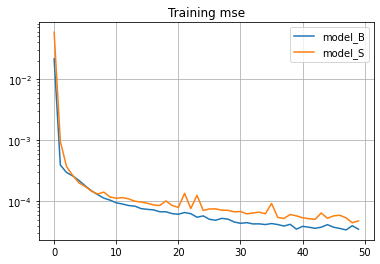

In [ ]:
# train mse compare
plt.plot(log['model_B'][0], label='model_B')
plt.plot(log['model_S'][0], label='model_S')
plt.title("Training mse")
plt.semilogy()  # y축에 log scale적용
plt.grid(True)
plt.legend(loc='best')
plt.show()  

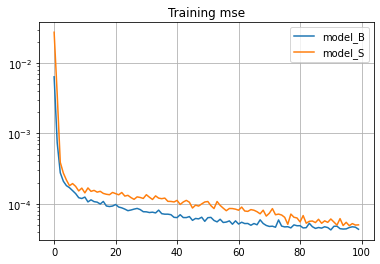

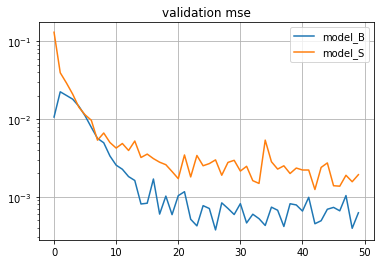

In [ ]:
# val mse compare
plt.plot(log['model_B'][1], label='model_B')
plt.plot(log['model_S'][1], label='model_S')

plt.title("validation mse")
plt.semilogy()
plt.grid(True)
plt.legend(loc='best')
plt.show()  

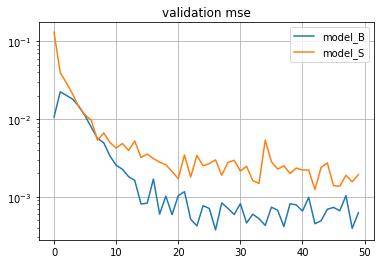

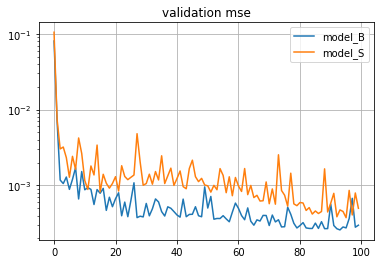

##### Predict the stock price

##### Plot the result

In [ ]:
def stock_plot(y,p1,p2):
    plt.figure(figsize=(10, 6))
    plt.plot(y, color = 'green', label = 'Stock Price')
    plt.plot(p1, color = 'blue',label = 'Predicted Stock Price_B')
    plt.plot(p2, color = 'red', label = 'Predicted Stock Price_S')
    # 
    plt.xlabel('days')
    plt.ylabel('Normalized Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    return 

In [ ]:
# 학습영역 마지막 100일 
s_p = -100
e_p =-1
X = x_train[s_p:e_p]
Y = y_train[s_p:e_p]

model_S.eval()
model_B.eval()

BasicModel(
  (lstm): LSTM(6, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

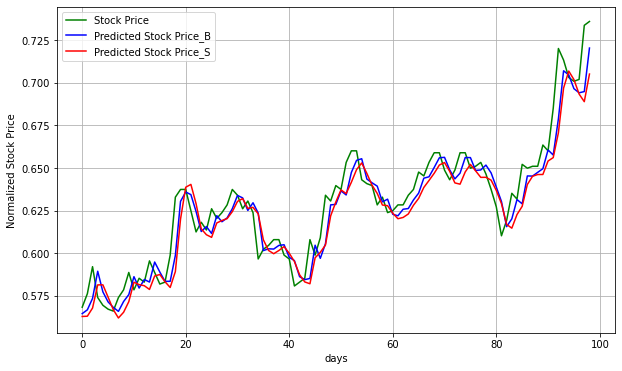

In [ ]:
# 학습영역 마지막 100일 
s_p = -100
e_p =-1
X = x_train[s_p:e_p]
Y = y_train[s_p:e_p]
predicted_stock_price_B = model_B(torch.Tensor(X))
predicted_stock_price_A = model_S(torch.Tensor(X))
stock_plot(Y, predicted_stock_price_B.detach(), predicted_stock_price_A.detach())

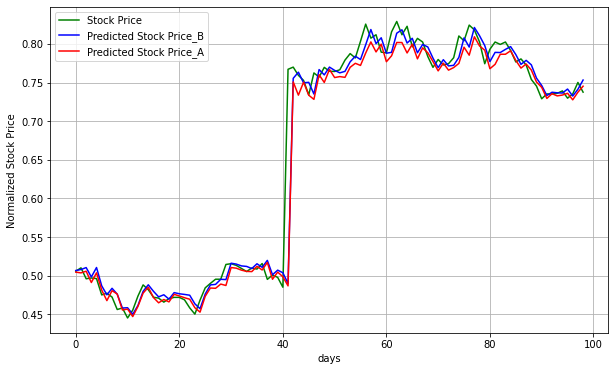

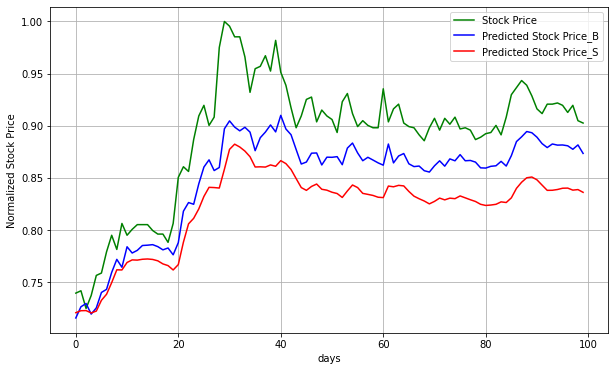

In [ ]:
# Test 첫 100일
s_p = 0
e_p = 100
X = x_test[s_p:e_p]
Y = y_test[s_p:e_p]
predicted_stock_price_B = model_B(torch.Tensor(X))
predicted_stock_price_A = model_S(torch.Tensor(X))
stock_plot(Y, predicted_stock_price_B.detach(), predicted_stock_price_A.detach())

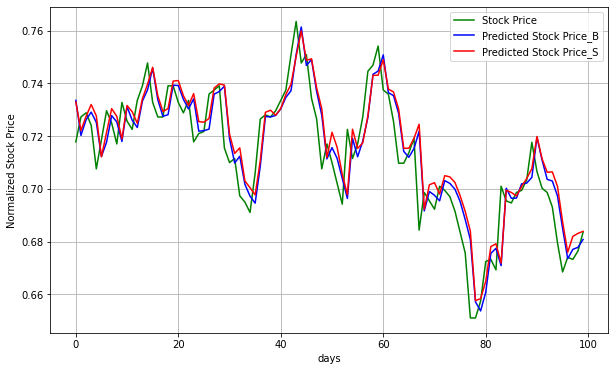

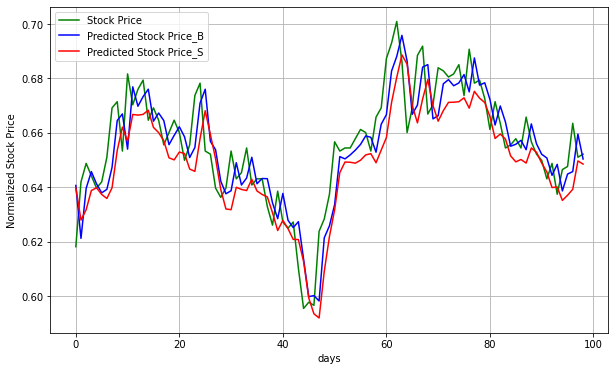

In [ ]:
# Test 영역 마지막 100일
s_p = -100
e_p = -1
X = x_test[s_p:e_p]
Y = y_test[s_p:e_p]
predicted_stock_price_B = model_B(torch.Tensor(X))
predicted_stock_price_A = model_S(torch.Tensor(X))
stock_plot(Y, predicted_stock_price_B.detach(), predicted_stock_price_A.detach())  

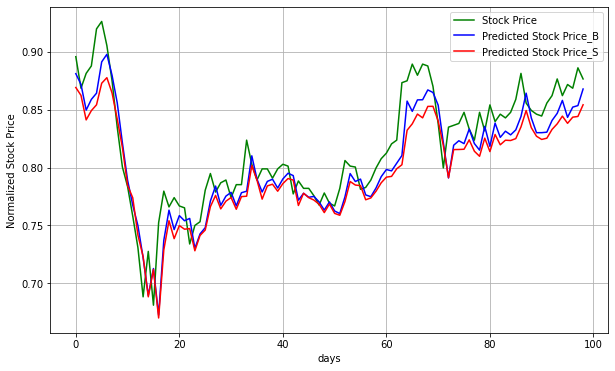

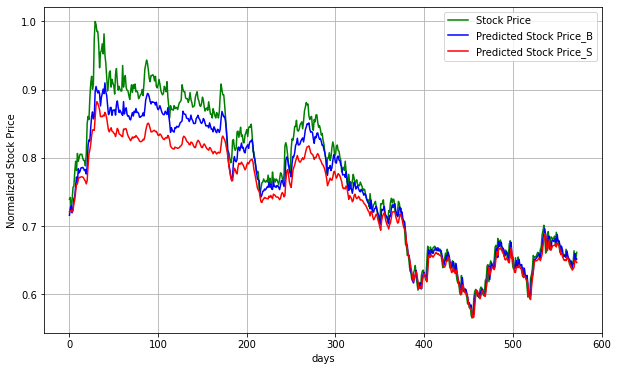

In [ ]:
# Test 영역 전체 
X = x_test
Y = y_test
predicted_stock_price_B = model_B(torch.Tensor(X))
predicted_stock_price_A = model_S(torch.Tensor(X))
stock_plot(Y, predicted_stock_price_B.detach(), predicted_stock_price_A.detach())

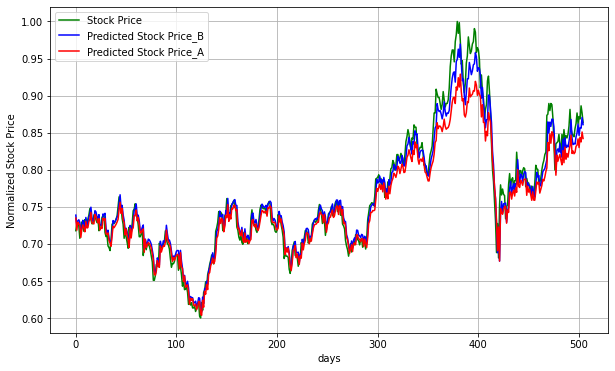

In [ ]:
STOP!

#### **실습 과제**

##### 과제 1. `timesteps = seq_length = 7`를 줄여보자 
###### -- model_B에서 5,3,1로 줄이고 결과를 비교하고, 설명해 보자

##### 과제 2. model_S를 교재와 같이 확장시켜 model_S2를 만들어 보자
###### -- dropout option을 추가해 보자, 
###### -- 결과를 model_B,S,S2에 대해 비교 설명해 보자  






##### 과제 3. LSTM을 사용하지 않고, Dense layer로 교체한 model을 만들어 보자 
###### -- model-B를 수정한 model-D를 만들어 비교 설명해 보자  

아래에 설계코드를 넣으세요

#### 실습결과 예시 

과제 3 Dense model 

In [ ]:
class DenseModel(pl.LightningModule):
    def __init__(self, input_features):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_features, 50),
            nn.Linear(50, 1)
        )
        
    def forward(self, x):
        x = self.linear(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [ ]:
model_d = DenseModel(x_train.shape[1]*x_train.shape[2]) #7*5
summary(model_d, input_size=x_train[:2].shape) #(2,7,5)  

Layer (type:depth-idx)                   Output Shape              Param #
DenseModel                               [2, 1]                    --
├─Sequential: 1-1                        [2, 1]                    --
│    └─Flatten: 2-1                      [2, 42]                   --
│    └─Linear: 2-2                       [2, 50]                   2,150
│    └─Linear: 2-3                       [2, 1]                    51
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [ ]:
trainer3 = Trainer(max_epochs=50,accelerator="auto")
trainer3.fit(model_d, trainDataLoader, testDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | linear | Sequential | 2.2 K 
--------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
v_num_d = model_d.logger.version  
log_dir = f'lightning_logs/version_{v_num_B}'

In [ ]:
event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

steps = {x.step for x in event_accumulator.Scalars("epoch")}
val_loss = [x.value for x in event_accumulator.Scalars('val_loss') if x.step in steps]
train_loss = [x.value for x in event_accumulator.Scalars('loss') if x.step in steps]
log['model_d'] = [train_loss, val_loss]

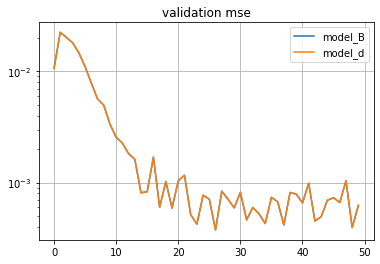

In [ ]:
# val mse compare
plt.plot(log['model_B'][1], label='model_B')
plt.plot(log['model_d'][1], label='model_d')

plt.title("validation mse")
plt.semilogy()
plt.grid(True)
plt.legend(loc='best')
plt.show()  

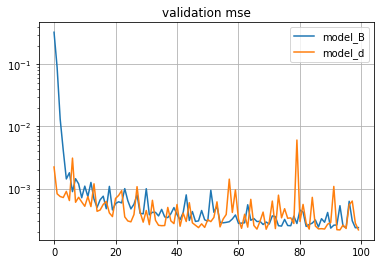

In [ ]:
model_d.eval()

DenseModel(
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=42, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

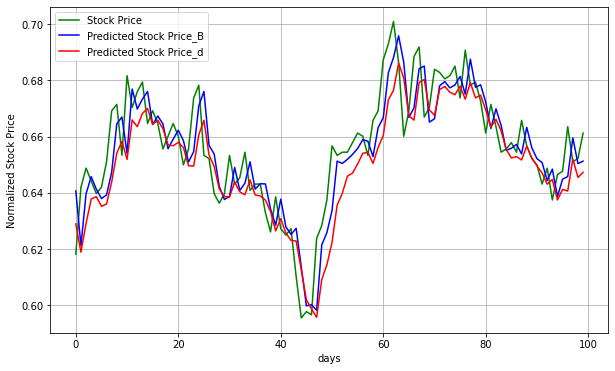

In [ ]:
# Test 마지막 100일  
X = x_test[-100:]
Y = y_test[-100:]
predicted_stock_price_B = model_B(torch.Tensor(X))
predicted_stock_price_d = model_d(torch.Tensor(X))

plt.figure(figsize=(10, 6))
plt.plot(Y[-100:], color = 'green', label = 'Stock Price')
plt.plot(predicted_stock_price_B.detach(), color = 'blue',label = 'Predicted Stock Price_B')
plt.plot(predicted_stock_price_d.detach(), color = 'red', label = 'Predicted Stock Price_d')
# 
plt.xlabel('days')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.grid(True)
plt.show()

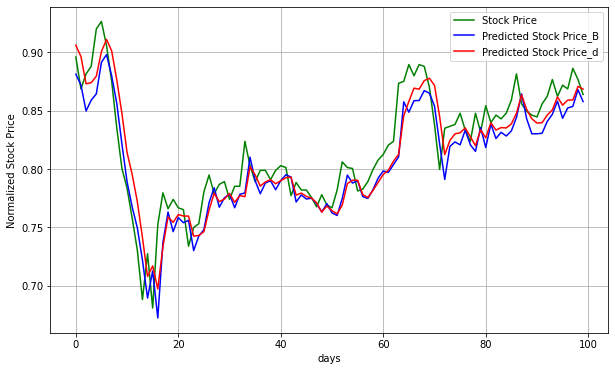